In [1]:
#import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import plotly.express as px
import plotly.graph_objects as go
from pathlib import Path
import pickle
import yaml

import importlib

import Model10_OOP_small
importlib.reload(Model10_OOP_small)
from Model10_OOP_small import ConvModel as ConvModel_small

import BaseData20Fold
importlib.reload(BaseData20Fold)
from BaseData20Fold import DataProcessor

import Plots
importlib.reload(Plots)
from Plots import plot_CM


# COntains 2stream Neural Network to process fine fatures and coarse features separate


In [2]:

cwd = Path.cwd()
%load_ext tensorboard
%load_ext version_information
#!rm -rf ./logs/

logsdir = cwd / '..' / 'logs'
# !rmdir /s /q {logsdir}
#!tensorboard --logdir {logsdir} --host localhost --port 6006

cfg = 'config_mdl10_small.yaml'
with open(cfg, 'r') as file:
    config = yaml.safe_load(file)
seeds = config['seeds']

folds = np.arange(1,21)

datapath = cwd / '..' / 'Data' / 'DHG2016' / 'small_windows'

In [ ]:
resultsDFlong = pd.DataFrame()
folder = 'small_windows'
data_processor = DataProcessor(cfg)
data_processor.load_handgestdata()
data_processor.handangles2windows()
data_processor.save_config(folder)
data_processor.save_windowsets(folder)

#folds = [5]
    
for fold in folds:
    data_processor = DataProcessor(cfg, fold = fold)
    # data_processor.load_handgestdata()
    # data_processor.handangles2windows()
    # data_processor.save_windowsets(folder)
    data_processor.load_windows(folder)
    data_processor.processwindows()
    data_processor.save_windowsets_processed(folder, name='Fold'+str(fold))


In [12]:
datapath = cwd / '..' / 'Data' / 'DHG2016' / 'small_windows'

results_valid_labels_list = []
results_scores_list_valid = []
results_scores_list_train = []


for seedidx, n_fold in enumerate(folds):
    print('evaluating Fold', n_fold)
    seed_val = seeds[seedidx]

    fold = pickle.load(open((datapath / ('Fold' + str(n_fold) + '.pkl')).resolve(), 'rb'))
    Y_train_oh = fold['train']['Y_oh']
    Y_valid_oh = fold['valid']['Y_oh']
    X_train = fold['train']['X']
    X_valid = fold['valid']['X']
  

    like7_small = ConvModel_small(cfg, 'Test', seed = seed_val)
    like7_small.compile_model()

    # Train the model
    like7_small.train_model(X_train, Y_train_oh, X_valid, Y_valid_oh)

    Y_prob_train = like7_small.model.predict(X_train)
    Y_prob_valid = like7_small.model.predict(X_valid)
    Y_score_true = np.max(Y_prob_valid, axis=-1)

    Y_hat_train = np.argmax(Y_prob_train, axis=-1)
    Y_hat_valid = np.argmax(Y_prob_valid, axis=-1)

    results_train = like7_small.model.evaluate(X_train, Y_train_oh, verbose = 0, return_dict=True)
    results_valid = like7_small.model.evaluate(X_valid, Y_valid_oh, verbose = 0, return_dict=True)

    print(f'NLL: {results_valid['NLL']:,.2f}')
    #print(f'Validation score: {results['loss']:,.2f}')
    print(f'Validation accuracy: {results_valid['accuracy']:,.2f}')
    print(f'Validation F1Score: {results_valid['f1_score']:,.2f}')

    results_valid_labels_list.append(pd.DataFrame({'Fold': n_fold, 'Y': fold['valid']['Y'], 'Y_hat': Y_hat_valid, 'Y_prob': Y_score_true}))
    results_scores_list_train.append(pd.DataFrame(results_train, index = [n_fold]))
    results_scores_list_valid.append(pd.DataFrame(results_valid, index = [n_fold]))
    #results_scores_list.append({'Fold': n_fold, 'Accuracy_train': accuracy_train, 'Accuracy_valid': accuracy_valid, 'F1-Score_train': f1_score_train, 'F1-Score_valid': f1_score_valid, 'NLL_train': nll_train, 'NLL_valid': nll_valid})
    
results_scores = pd.concat([pd.concat(results_scores_list_train).add_suffix('_train'),pd.concat(results_scores_list_valid).add_suffix('_valid')],axis = 1)
results_scores.rename(columns = {'fold_train': 'fold'}, inplace = True)
results_valid_labels = pd.concat(results_valid_labels_list)


evaluating Fold 1
Setting seed to 5
Epoch 1/20
844/844 - 20s - 24ms/step - NLL: 1.5575 - accuracy: 0.5169 - f1_score: 0.2869 - loss: 1.8086 - precision: 0.6743 - recall: 0.3065 - val_NLL: 1.5190 - val_accuracy: 0.4870 - val_f1_score: 0.2990 - val_loss: 1.7153 - val_precision: 0.6432 - val_recall: 0.3608
Epoch 2/20
844/844 - 17s - 20ms/step - NLL: 1.2151 - accuracy: 0.6010 - f1_score: 0.4391 - loss: 1.4115 - precision: 0.7400 - recall: 0.4422 - val_NLL: 1.4016 - val_accuracy: 0.5265 - val_f1_score: 0.3692 - val_loss: 1.5854 - val_precision: 0.6599 - val_recall: 0.4246
Epoch 3/20
844/844 - 15s - 18ms/step - NLL: 1.1176 - accuracy: 0.6304 - f1_score: 0.4895 - loss: 1.3104 - precision: 0.7600 - recall: 0.4856 - val_NLL: 1.3411 - val_accuracy: 0.5438 - val_f1_score: 0.4072 - val_loss: 1.5235 - val_precision: 0.6653 - val_recall: 0.4432
Epoch 4/20
844/844 - 14s - 17ms/step - NLL: 1.0543 - accuracy: 0.6495 - f1_score: 0.5173 - loss: 1.2485 - precision: 0.7713 - recall: 0.5143 - val_NLL: 1.311

In [13]:
results_valid_labels.to_pickle(datapath/'results_valid_labels_dcnn.pkl')
results_scores.to_pickle(datapath/'results_scores_dcnn.pkl')

In [8]:
results_scores.columns

Index(['NLL_train', 'accuracy_train', 'f1_score_train', 'loss_train',
       'precision_train', 'recall_train', 'NLL_valid', 'accuracy_valid',
       'f1_score_valid', 'loss_valid', 'precision_valid', 'recall_valid'],
      dtype='object')

In [14]:
mean = results_scores.mean()
std = results_scores.std()

print(f'accuracy on training data - frames: {mean["accuracy_train"]*100:.1f}% +-  {std["accuracy_train"]*100:.1f}%')
print(f'F1_Score on training data - frames: {mean["f1_score_train"]*100:.1f}% +- {std["f1_score_train"]*100:.1f}%')
print(f'NLL on training data - frames: {mean["NLL_train"]:.2f} +- {std["NLL_train"]:.2f}')

print(f'accuracy on validation data - frames: {mean['accuracy_valid']*100:.1f}% +- {std['accuracy_valid']*100:.1f}%')
print(f'F1-Score on validation data - frames: {mean['f1_score_valid']*100:.1f}% +- {std['f1_score_valid']*100:.1f}%')
print(f'NLL on validation data - frames: {mean['NLL_valid']:.2f} +- {std['NLL_valid']:.2f}')

accuracy on training data - frames: 72.3% +-  1.4%
F1_Score on training data - frames: 63.0% +- 2.5%
NLL on training data - frames: 0.79 +- 0.04
accuracy on validation data - frames: 63.7% +- 4.2%
F1-Score on validation data - frames: 49.0% +- 7.0%
NLL on validation data - frames: 1.13 +- 0.16


In [11]:
mean = results_scores.mean()
std = results_scores.std()

print(f'accuracy on training data - frames: {mean["accuracy_train"]*100:.1f}% +-  {std["accuracy_train"]*100:.1f}%')
print(f'F1_Score on training data - frames: {mean["f1_score_train"]*100:.1f}% +- {std["f1_score_train"]*100:.1f}%')
print(f'NLL on training data - frames: {mean["NLL_train"]:.2f} +- {std["NLL_train"]:.2f}')

print(f'accuracy on validation data - frames: {mean['accuracy_valid']*100:.1f}% +- {std['accuracy_valid']*100:.1f}%')
print(f'F1-Score on validation data - frames: {mean['f1_score_valid']*100:.1f}% +- {std['f1_score_valid']*100:.1f}%')
print(f'NLL on validation data - frames: {mean['NLL_valid']:.2f} +- {std['NLL_valid']:.2f}')


accuracy on training data - frames: 58.3% +-  2.2%
F1_Score on training data - frames: 60.0% +- 2.2%
NLL on training data - frames: 1.16 +- 0.06
accuracy on validation data - frames: 47.0% +- 5.2%
F1-Score on validation data - frames: 45.1% +- 5.9%
NLL on validation data - frames: 1.56 +- 0.17


In [128]:
print(resultsDF.std())
print(resultsDF.mean())

fold        2.449490
seed        0.000000
NLL         0.163328
accuracy    0.044899
f1_score    0.056034
dtype: float64
fold         4.500000
seed        26.000000
NLL          1.265158
accuracy     0.589345
f1_score     0.536435
dtype: float64


In [120]:
y_scores_valid = like7.model.predict(foldsprocessors[1].window_sets_processed['valid']['X'])
Y_hat_valid = np.argmax(y_scores_valid, axis=1)

plot_CM(foldsprocessors[1].window_sets_processed['valid']['Y'], Y_hat_valid, 'Confusion Matrix Validation Data', percentagereference='recall')
plot_CM(foldsprocessors[1].window_sets_processed['valid']['Y'], Y_hat_valid, 'Confusion Matrix Validation Data', percentagereference='precision')

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


In [46]:
resultsDF

,fold,seed,NLL,accuracy,f1_score
0,1,26,2.084593,0.3322,0.311073


In [52]:
nameofrun = 'shortsequences_juststandardization'
jsonpath = cwd / '..' / 'logs' / 'jsons' / ('resultsDF_' + nameofrun + '.json')
resultsDF.to_json(jsonpath)

In [7]:
nameofrun = 'shortsequences_juststandardization'
jsonpath = cwd / '..' / 'logs' / 'jsons' / ('resultsDF_' + nameofrun + '.json')
resultsDF = pd.read_json(jsonpath)

FileNotFoundError: File c:\Users\mado\Documents\gesture_class\Skripts\..\logs\jsons\resultsDF_shortsequences_juststandardization.json does not exist

1[{"variableName": "ID_TO_MEANING", "type": "dictionary", "supportedEngines": ["pandas"], "isLocalVariable": true}]

1[{"variableName": "ID_TO_MEANING", "type": "dictionary", "supportedEngines": ["pandas"], "isLocalVariable": true}]



In [50]:
output = resultsDF.groupby('seed').std()
print(f'{output:,.2f}')

NLL         1.107232
accuracy    0.683482
f1_score    0.677128
dtype: float64
NLL         0.116826
accuracy    0.061265
f1_score    0.065539
dtype: float64
             fold       NLL  accuracy  f1_score
seed                                           
26        2.44949  0.216514  0.070114  0.070662
1027      2.44949  0.116826  0.061265  0.065539
52408     2.44949  0.176356  0.046875  0.047720
786191    2.44949  0.175712  0.060124  0.061050
3907426   2.44949  0.171898  0.058209  0.059100
80337754  2.44949  0.212079  0.060381  0.057158


In [121]:
with open(cwd / '..' / 'Data' / 'DHG2016' / 'data_old_ws50.pkl', "rb") as fp:
    dada_old = pickle.load(fp)

X_train_ = dada_old['X_train']
Y_train_oh_ = dada_old['Y_train_oh']
X_valid_ = dada_old['X_valid']
Y_valid_oh_ = dada_old['Y_valid_oh']


In [115]:

infos = dada_old['T_train']
infos.loc[(infos['n_subject'] == 6) & (infos['n_gesture'] == 1) & (infos['n_finger'] == 1) & (infos['n_essai'] == 1),:]

,label,frametimestamps,n_gesture,n_finger,n_subject,n_essai
0,0,0.889422,1,1,6,1
0,0,1.070939,1,1,6,1
0,0,1.252454,1,1,6,1
0,1,1.433970,1,1,6,1
0,1,1.615488,1,1,6,1
0,1,1.797004,1,1,6,1
0,1,1.978518,1,1,6,1
0,1,2.160035,1,1,6,1
0,1,2.341551,1,1,6,1


In [116]:

# Example usage
like7_ = ConvModel('config_mdl10_small.yaml', 'Test')
like7_.compile_model()


# Train the model
#like7.train_model(X_train_angles, X_train_pointquat, Y_train_oh, X_valid_angles, X_valid_pointquat, Y_valid_oh)
like7_.train_model(X_train_, Y_train_oh_, X_valid_, Y_valid_oh_)
#results = like7.model.evaluate([X_valid_angles, X_valid_pointquat], Y_valid_oh, verbose = 0, return_dict=True)
#results

Setting seed to 26
Epoch 1/20
299/299 - 17s - 57ms/step - NLL: 2.0852 - accuracy: 0.3345 - f1_score: 0.2774 - loss: 2.3061 - precision: 0.5825 - recall: 0.1021 - val_NLL: 1.6051 - val_accuracy: 0.5164 - val_f1_score: 0.4099 - val_loss: 1.8875 - val_precision: 0.7115 - val_recall: 0.2346
Epoch 2/20
299/299 - 7s - 22ms/step - NLL: 1.6779 - accuracy: 0.4624 - f1_score: 0.4241 - loss: 1.7228 - precision: 0.6512 - recall: 0.2638 - val_NLL: 1.4840 - val_accuracy: 0.5423 - val_f1_score: 0.4640 - val_loss: 1.7496 - val_precision: 0.7095 - val_recall: 0.3451
Epoch 3/20
299/299 - 7s - 24ms/step - NLL: 1.5354 - accuracy: 0.4971 - f1_score: 0.4714 - loss: 1.5066 - precision: 0.6708 - recall: 0.3342 - val_NLL: 1.4517 - val_accuracy: 0.5484 - val_f1_score: 0.4830 - val_loss: 1.7152 - val_precision: 0.6928 - val_recall: 0.3794
Epoch 4/20
299/299 - 9s - 29ms/step - NLL: 1.4548 - accuracy: 0.5246 - f1_score: 0.5036 - loss: 1.3964 - precision: 0.6837 - recall: 0.3732 - val_NLL: 1.3526 - val_accuracy: 0.

In [117]:
results = like7_.model.evaluate(X_valid_, Y_valid_oh_, verbose = 0, return_dict=True)
results

{'NLL': 1.1089835166931152,
 'accuracy': 0.6419028043746948,
 'f1_score': 0.5647571682929993,
 'loss': 1.4047657251358032,
 'precision': 0.7482824921607971,
 'recall': 0.5512145757675171}

In [122]:
y_scores_valid = like7_.model.predict(dada_old['X_valid'])
Y_hat_valid = np.argmax(y_scores_valid, axis=1)

plot_CM(dada_old['Y_valid'], Y_hat_valid, 'Confusion Matrix Validation Data old', percentagereference='recall')
plot_CM(dada_old['Y_valid'], Y_hat_valid, 'Confusion Matrix Validation Data_old', percentagereference='precision')

155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [42]:
like7.model.summary()


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 4, 302, 5) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1.5d_1 (Conv2D) │ (None, 1, 300, 6) │        366 │ input_layer_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_6 (Reshape) │ (None, 300, 6)    │          0 │ conv1.5d_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_13      │ (None, 300, 7)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_36 (Conv1D)  │ (None, 298, 16)   │        304 │ reshape_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_39 (Conv1D)  │ (None, 298, 16)   │        352 │ input_layer_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_37 (Conv1D)  │ (None, 294, 64)   │      3,136 │ conv1d_36[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_40 (Conv1D)  │ (None, 294, 64)   │      3,136 │ conv1d_39[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_38 (Conv1D)  │ (None, 286, 64)   │     12,352 │ conv1d_37[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_41 (Conv1D)  │ (None, 286, 64)   │     12,352 │ conv1d_40[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_12    │ (None, 95, 64)    │          0 │ conv1d_38[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_13    │ (None, 95, 64)    │          0 │ conv1d_41[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 95, 128)   │          0 │ max_pooling1d_12… │
│ (Concatenate)       │                   │            │ max_pooling1d_13… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_6 (Flatten) │ (None, 12160)     │          0 │ concatenate_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 200)       │  2,432,200 │ flatten_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 200)       │          0 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 14)        │      2,814 │ dropout_6[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,401,038 (28.23 MB)

 Trainable params: 2,467,012 (9.41 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,934,026 (18.82 MB)

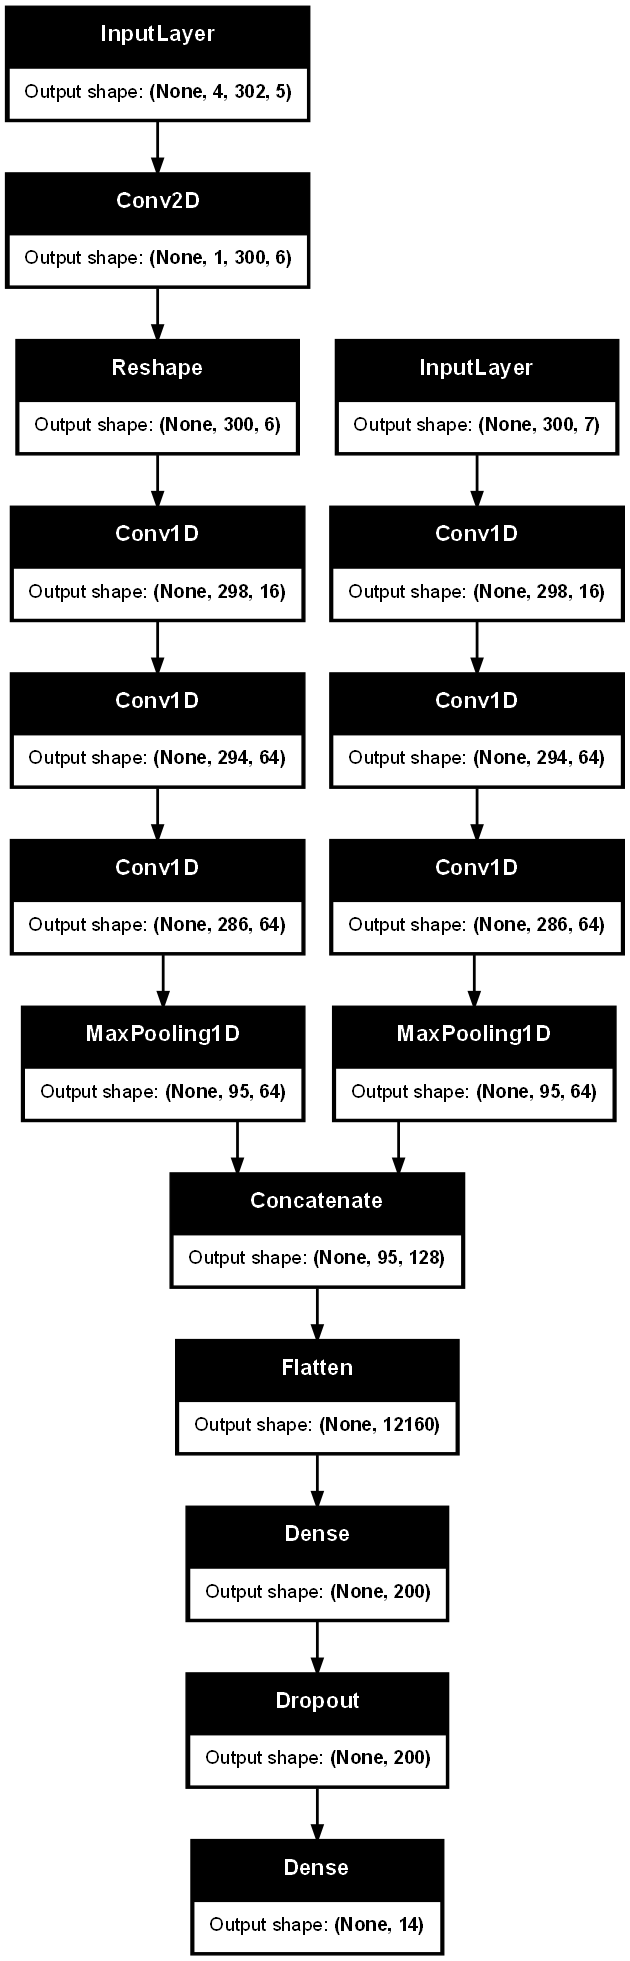

In [43]:
keras.utils.plot_model(like7.model, show_shapes=True, rankdir = 'TB', dpi = 100, to_file='model7.png')

In [ ]:
resultsDF = pd.DataFrame()

In [ ]:
# validation score is influenced by regularization terms!!!!
results = like7.model.evaluate([X_valid_angles, X_valid_pointquat], Y_valid_oh, verbose = 0, return_dict=True)
print(f'NLL: {results['NLL']:,.2f}')
#print(f'Validation score: {results['loss']:,.2f}')
print(f'Validation accuracy: {results['accuracy']:,.2f}')
print(f'Validation F1Score: {results['f1_score']:,.2f}')
#%%


# NLL: 0.95
# Validation accuracy: 0.73
# Validation F1Score: 0.73
results

In [112]:


y_scores_valid = like7.model.predict(foldsprocessors[1].window_sets_processed['valid']['X'])
Y_hat_valid = np.argmax(y_scores_valid, axis=1)

plot_CM(foldsprocessors[1].window_sets_processed['valid']['Y'], Y_hat_valid, 'Confusion Matrix Validation Data', percentagereference='recall')
plot_CM(foldsprocessors[1].window_sets_processed['valid']['Y'], Y_hat_valid, 'Confusion Matrix Validation Data', percentagereference='precision')

# T_valid.loc[:, 'Y_hat'] = Y_hat_valid
# T_valid.loc[:, 'Y'] = Y_valid
# T_valid.loc[:, 'Y_score_true'] = y_scores_valid[np.arange(y_scores_valid.shape[0]), Y_valid]
# T_valid.loc[:, 'Y_score_nogest'] = y_scores_valid[:, 0]
# T_valid

91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


In [113]:
plot_CM(foldsprocessors[1].window_sets_processed['valid']['Y'], Y_hat_valid, 'Confusion Matrix Validation Data', percentagereference='recall')
plot_CM(foldsprocessors[1].window_sets_processed['valid']['Y'], Y_hat_valid, 'Confusion Matrix Validation Data', percentagereference='precision')

In [ ]:
px.histogram(T_valid.loc[(T_valid['n_gesture']==7) & (T_valid['Y']==0), 'Y_hat'], nbins = 15)


|# |	Name of the gesture |	Type of the gesture|
| --- | --- | --- |
|1 	|Grab 	        |Fine|
|2 	|Tap 	        |Coarse|
|3 	|Expand 	    |Fine|
|4 	|Pinch 	        |Fine|
|5 	|Rotation CW 	|Fine|
|6 	|Rotation CCW 	|Fine|
|7 	|Swipe Right 	|Coarse|
|8 	|Swipe Left 	|Coarse|
|9 	|Swipe Up 	    |Coarse|
|10 |	Swipe Down 	|Coarse|
|11 |	Swipe X 	|Coarse|
|12 |	Swipe V 	|Coarse|
|13 |	Swipe + 	|Coarse|
|14 |	Shake 	    |Coarse |

In [ ]:
%version_information tensorflow, numpy, matplotlib, plotly, pandas, keras